# Deep Convolutional Generative Adversarial Network

## Imports

In [1]:
import os
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.train import Checkpoint, CheckpointManager
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.layers import Input, Dense, Reshape, BatchNormalization, Conv2D, Conv2DTranspose, \
        LeakyReLU, Flatten, SpatialDropout2D, Dropout, MaxPool2D, GlobalAvgPool2D, Concatenate, LayerNormalization

from IPython import display

print(tf.__version__)

2.3.0


In [2]:
tf.get_logger().setLevel('ERROR')

## Constants

### Data Constants

In [3]:
BASE_PATH = r'../Dataset/img_align_celeba'
RANDOM_STATE = 7
SHUFFLE_BUFFER = 32_000
IMAGE_SIZE = (192, 160)
BATCH_SIZE = 32
GEN_NOISE_SHAPE = (6, 5, 8)
PREDICT_COUNT = 9

### Model Constants

In [4]:
GEN_LR = 1e-6
GEN_BETA_1 = 0.5
DISC_LR = 1e-6
DISC_BETA_1 = 0.9
GEN_RELU_ALPHA = 0.2
DISC_RELU_ALPHA = 0.3
EPOCHS = 30
DISC_LABEL_SMOOTHING = 0.3
PLOTS_DPI = 150
RETRAIN = os.path.isfile('./ckpt/checkpoint')

## Data Preparation

### Loading all image file names

In [5]:
%%time

image_names = Dataset.list_files(os.path.join(BASE_PATH, '*.jpg'), seed = RANDOM_STATE)
image_count = image_names.cardinality().numpy()
print(f"\nTotal number of image files: {image_count}\n")


Total number of image files: 202599

Wall time: 6.64 s


### Creating Data loading pipeline

In [6]:
def load_image_data(filename):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return (img - 127.5)/127.5

train_ds = image_names.cache() \
        .shuffle(SHUFFLE_BUFFER, seed = RANDOM_STATE) \
        .map(load_image_data, num_parallel_calls = AUTOTUNE) \
        .batch(BATCH_SIZE, drop_remainder = True) \
        .prefetch(buffer_size = AUTOTUNE)

train_ds

<PrefetchDataset shapes: (32, 192, 160, 3), types: tf.float32>

### Image data samples

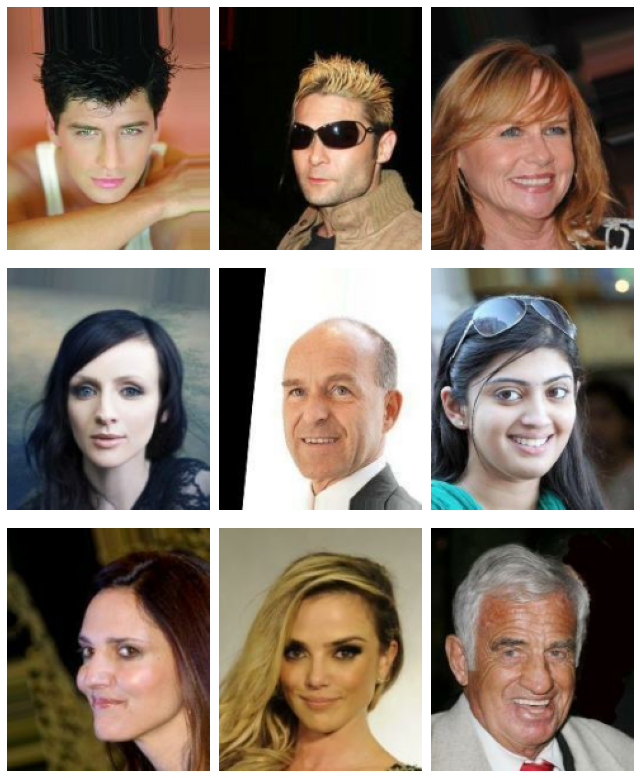

In [7]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11))

sample_images = [i for i in train_ds.take(1)][0].numpy()

for i, ax in enumerate(axes.flatten()):
    ax.imshow((sample_images[i] * 0.5) + 0.5)
    ax.axis(False)
    ax.grid(False)

plt.tight_layout()

### Noise data input for `generator` model

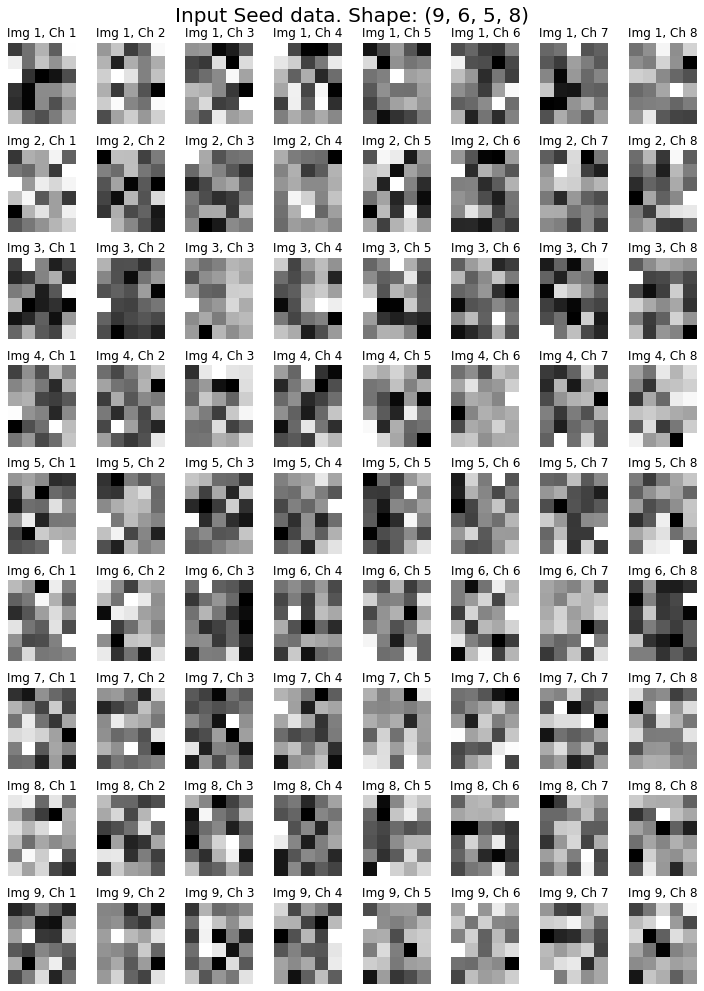

In [8]:
seed_noise = tf.random.normal([PREDICT_COUNT, *GEN_NOISE_SHAPE])

fig, axes = plt.subplots(nrows = PREDICT_COUNT, ncols = GEN_NOISE_SHAPE[2], figsize = (10, 14))

for i in range(PREDICT_COUNT):
    for j in range(GEN_NOISE_SHAPE[2]):
        axes[i][j].imshow(seed_noise[i, :, :, j], cmap = 'gray')
        axes[i][j].axis(False)
        axes[i][j].grid(False)
        axes[i][j].set_title(f"Img {i + 1}, Ch {j + 1}")
        
plt.suptitle(f'Input Seed data. Shape: {seed_noise.shape}', fontsize = 20)
plt.tight_layout()

## Model Creation

### Generator

In [9]:
def generator_model():
    weight_init = TruncatedNormal(mean = 0.0, stddev = 0.02)

    input_layer = Input(shape = GEN_NOISE_SHAPE, name = 'Gen_Input')
    flatten = Flatten(name = 'Gen_Flatten')(input_layer)
    dense = Dense(6 * 5 * 512, use_bias = False, kernel_initializer = weight_init, 
                activation = LeakyReLU(GEN_RELU_ALPHA), name = 'Gen_Dense')(flatten)
    reshape = Reshape((6, 5, 512), name = 'Gen_Reshape')(dense)
    sp_dropout_1 = SpatialDropout2D(0.1, name = 'Gen_SD_1')(reshape)


    conv_T_1 = Conv2DTranspose(512, (3, 3), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA), use_bias = False,
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_1')(sp_dropout_1) 
    conv_T_2 = Conv2DTranspose(256, (3, 3), padding = 'same', strides = (2, 2), use_bias = False,
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_2')(conv_T_1)
    bn_1 = BatchNormalization(name = 'Gen_BN_1')(conv_T_2)
    lr_1 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_1')(bn_1)   


    conv_T_3 = Conv2DTranspose(128, (4, 4), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA), use_bias = False, 
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_3')(lr_1) 
    conv_T_4 = Conv2DTranspose(64, (4, 4), padding = 'same', strides = (2, 2), use_bias = False, 
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_4')(conv_T_3)
    bn_2 = BatchNormalization(name = 'Gen_BN_2')(conv_T_4)
    lr_2 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_2')(bn_2)
    sp_dropout_2 = SpatialDropout2D(0.1, name = 'Gen_SD_2')(lr_2)


    conv_T_5 = Conv2DTranspose(16, (5, 5), padding = 'same', strides = (2, 2), use_bias = False,
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_5')(sp_dropout_2)
    bn_3 = BatchNormalization(name = 'Gen_BN_3')(conv_T_5)
    lr_3 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_3')(bn_3)   
    sp_dropout_3 = SpatialDropout2D(0.1, name = 'Gen_SD_3')(lr_3)


    conv_T_6 = Conv2DTranspose(8, (6, 6), padding = 'same', strides = (2, 2), use_bias = False, 
                               kernel_initializer = weight_init, name = 'Gen_Conv_T_6')(sp_dropout_3)
    bn_4 = BatchNormalization(name = 'Gen_BN_4')(conv_T_6)
    lr_4 = LeakyReLU(GEN_RELU_ALPHA, name = 'Gen_LR_4')(bn_4)
    sp_dropout_4 = SpatialDropout2D(0.1, name = 'Gen_SD_4')(lr_4)


    conv_T_7 = Conv2DTranspose(8, (7, 7), padding = 'same', activation = LeakyReLU(GEN_RELU_ALPHA), use_bias = False,
                               kernel_initializer = weight_init, strides = (2, 2), name = 'Gen_Conv_T_7')(sp_dropout_4)
    conv_T_8 = Conv2DTranspose(3, (5, 5), padding = 'same', kernel_initializer = weight_init, use_bias = False,
                               activation = 'tanh', name = 'Gen_Conv_T_8')(conv_T_7)
    
    return Model(inputs = input_layer, outputs = conv_T_8, name = 'Generator')
    
generator = generator_model()
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gen_Input (InputLayer)       [(None, 6, 5, 8)]         0         
_________________________________________________________________
Gen_Flatten (Flatten)        (None, 240)               0         
_________________________________________________________________
Gen_Dense (Dense)            (None, 15360)             3686400   
_________________________________________________________________
Gen_Reshape (Reshape)        (None, 6, 5, 512)         0         
_________________________________________________________________
Gen_SD_1 (SpatialDropout2D)  (None, 6, 5, 512)         0         
_________________________________________________________________
Gen_Conv_T_1 (Conv2DTranspos (None, 6, 5, 512)         2359296   
_________________________________________________________________
Gen_Conv_T_2 (Conv2DTranspos (None, 12, 10, 256)       11

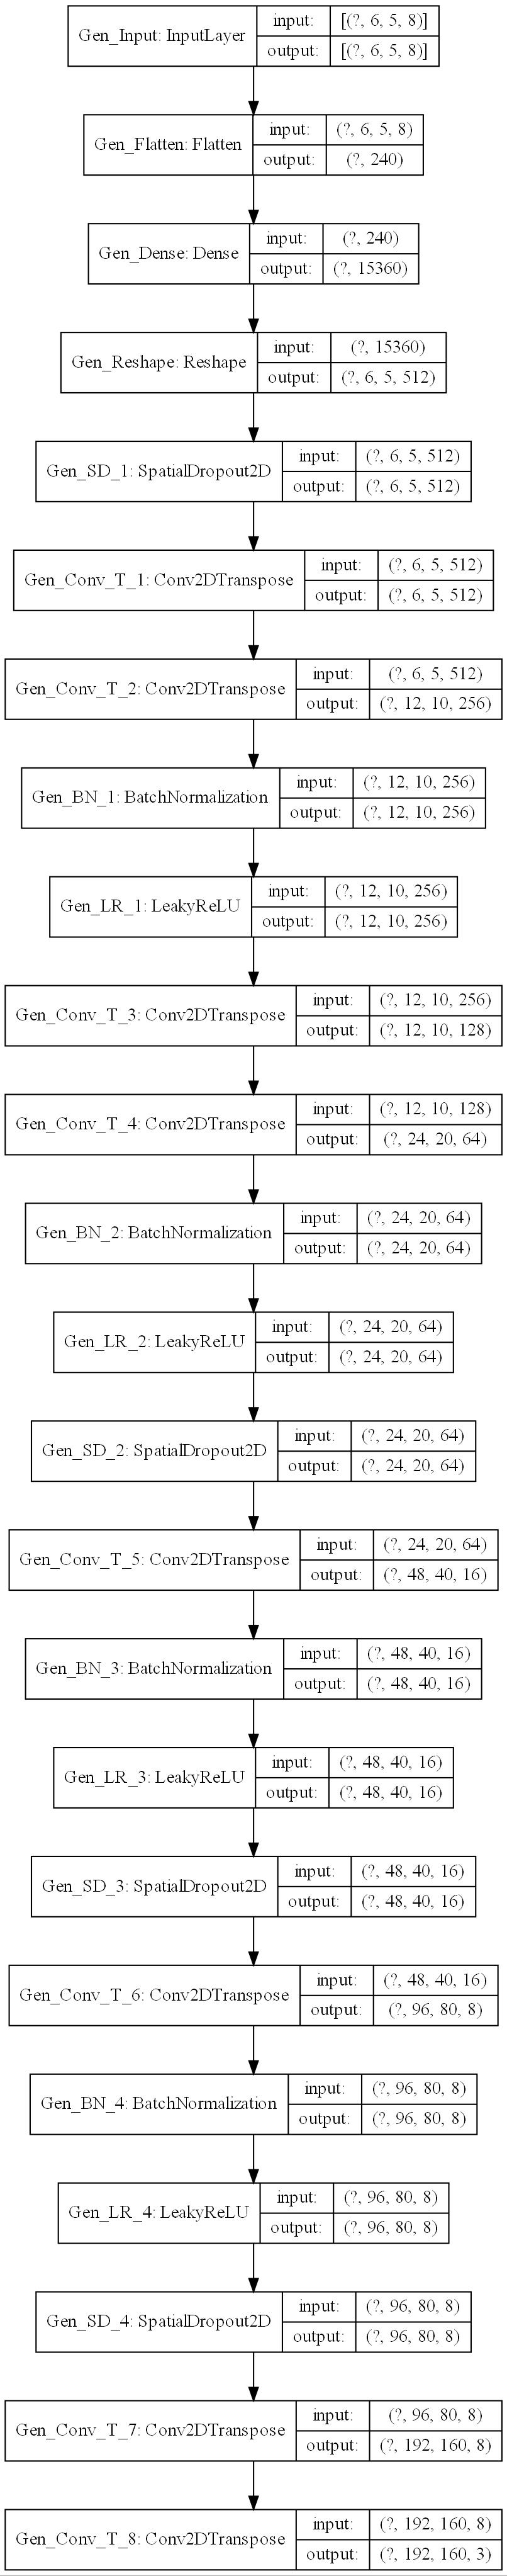

In [10]:
plot_model(generator, to_file = 'Generator.jpg', show_shapes = True, dpi = PLOTS_DPI)

### Discriminator

In [11]:
def discriminator_model():
    input_layer = Input(shape = (*IMAGE_SIZE, 3), name = 'Disc_Input')
    
    conv_1 = Conv2D(32, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_1')(input_layer)
    max_pool_1 = MaxPool2D(2, name = 'Disc_MP_1')(conv_1)
    conv_2 = Conv2D(64, (4, 4), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_2')(max_pool_1)
    max_pool_2 = MaxPool2D(2, name = 'Disc_MP_2')(conv_2)
    global_pool_1 = GlobalAvgPool2D(name = 'Disc_GAP_1')(max_pool_2)
    
    sp_dropout_1 = SpatialDropout2D(0.2, name = 'Disc_SD_1')(max_pool_2)
    conv_3 = Conv2D(128, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_3')(sp_dropout_1)
    max_pool_3 = MaxPool2D(2, name = 'Disc_MP_3')(conv_3)
    conv_4 = Conv2D(256, (3, 3), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_4')(max_pool_3)
    max_pool_4 = MaxPool2D(2, name = 'Disc_MP_4')(conv_4)
    global_pool_2 = GlobalAvgPool2D(name = 'Disc_GAP_2')(max_pool_4)
    
    sp_dropout_2 = SpatialDropout2D(0.2, name = 'Disc_SD_2')(max_pool_4)
    conv_5 = Conv2D(512, (2, 2), activation = LeakyReLU(DISC_RELU_ALPHA), padding = 'same', name = 'Disc_Conv_5')(sp_dropout_2)
    max_pool_5 = MaxPool2D(2, name = 'Disc_MP_5')(conv_5)
    global_pool_3 = GlobalAvgPool2D(name = 'Disc_GAP_3')(max_pool_5)
    
    concat = Concatenate(name = 'Disc_Concat')([global_pool_1, global_pool_2, global_pool_3])
    dropout = Dropout(0.2, name = 'Disc_Dropout')(concat)
    dense_1 = Dense(32, activation = LeakyReLU(DISC_RELU_ALPHA), name = 'Disc_Dense_1')(dropout)
    dense_2 = Dense(1, name = 'Disc_Dense_2')(dense_1)
    
    return Model(inputs = input_layer, outputs = dense_2, name = 'Discriminator')
    
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Disc_Input (InputLayer)         [(None, 192, 160, 3) 0                                            
__________________________________________________________________________________________________
Disc_Conv_1 (Conv2D)            (None, 192, 160, 32) 1568        Disc_Input[0][0]                 
__________________________________________________________________________________________________
Disc_MP_1 (MaxPooling2D)        (None, 96, 80, 32)   0           Disc_Conv_1[0][0]                
__________________________________________________________________________________________________
Disc_Conv_2 (Conv2D)            (None, 96, 80, 64)   32832       Disc_MP_1[0][0]                  
______________________________________________________________________________________

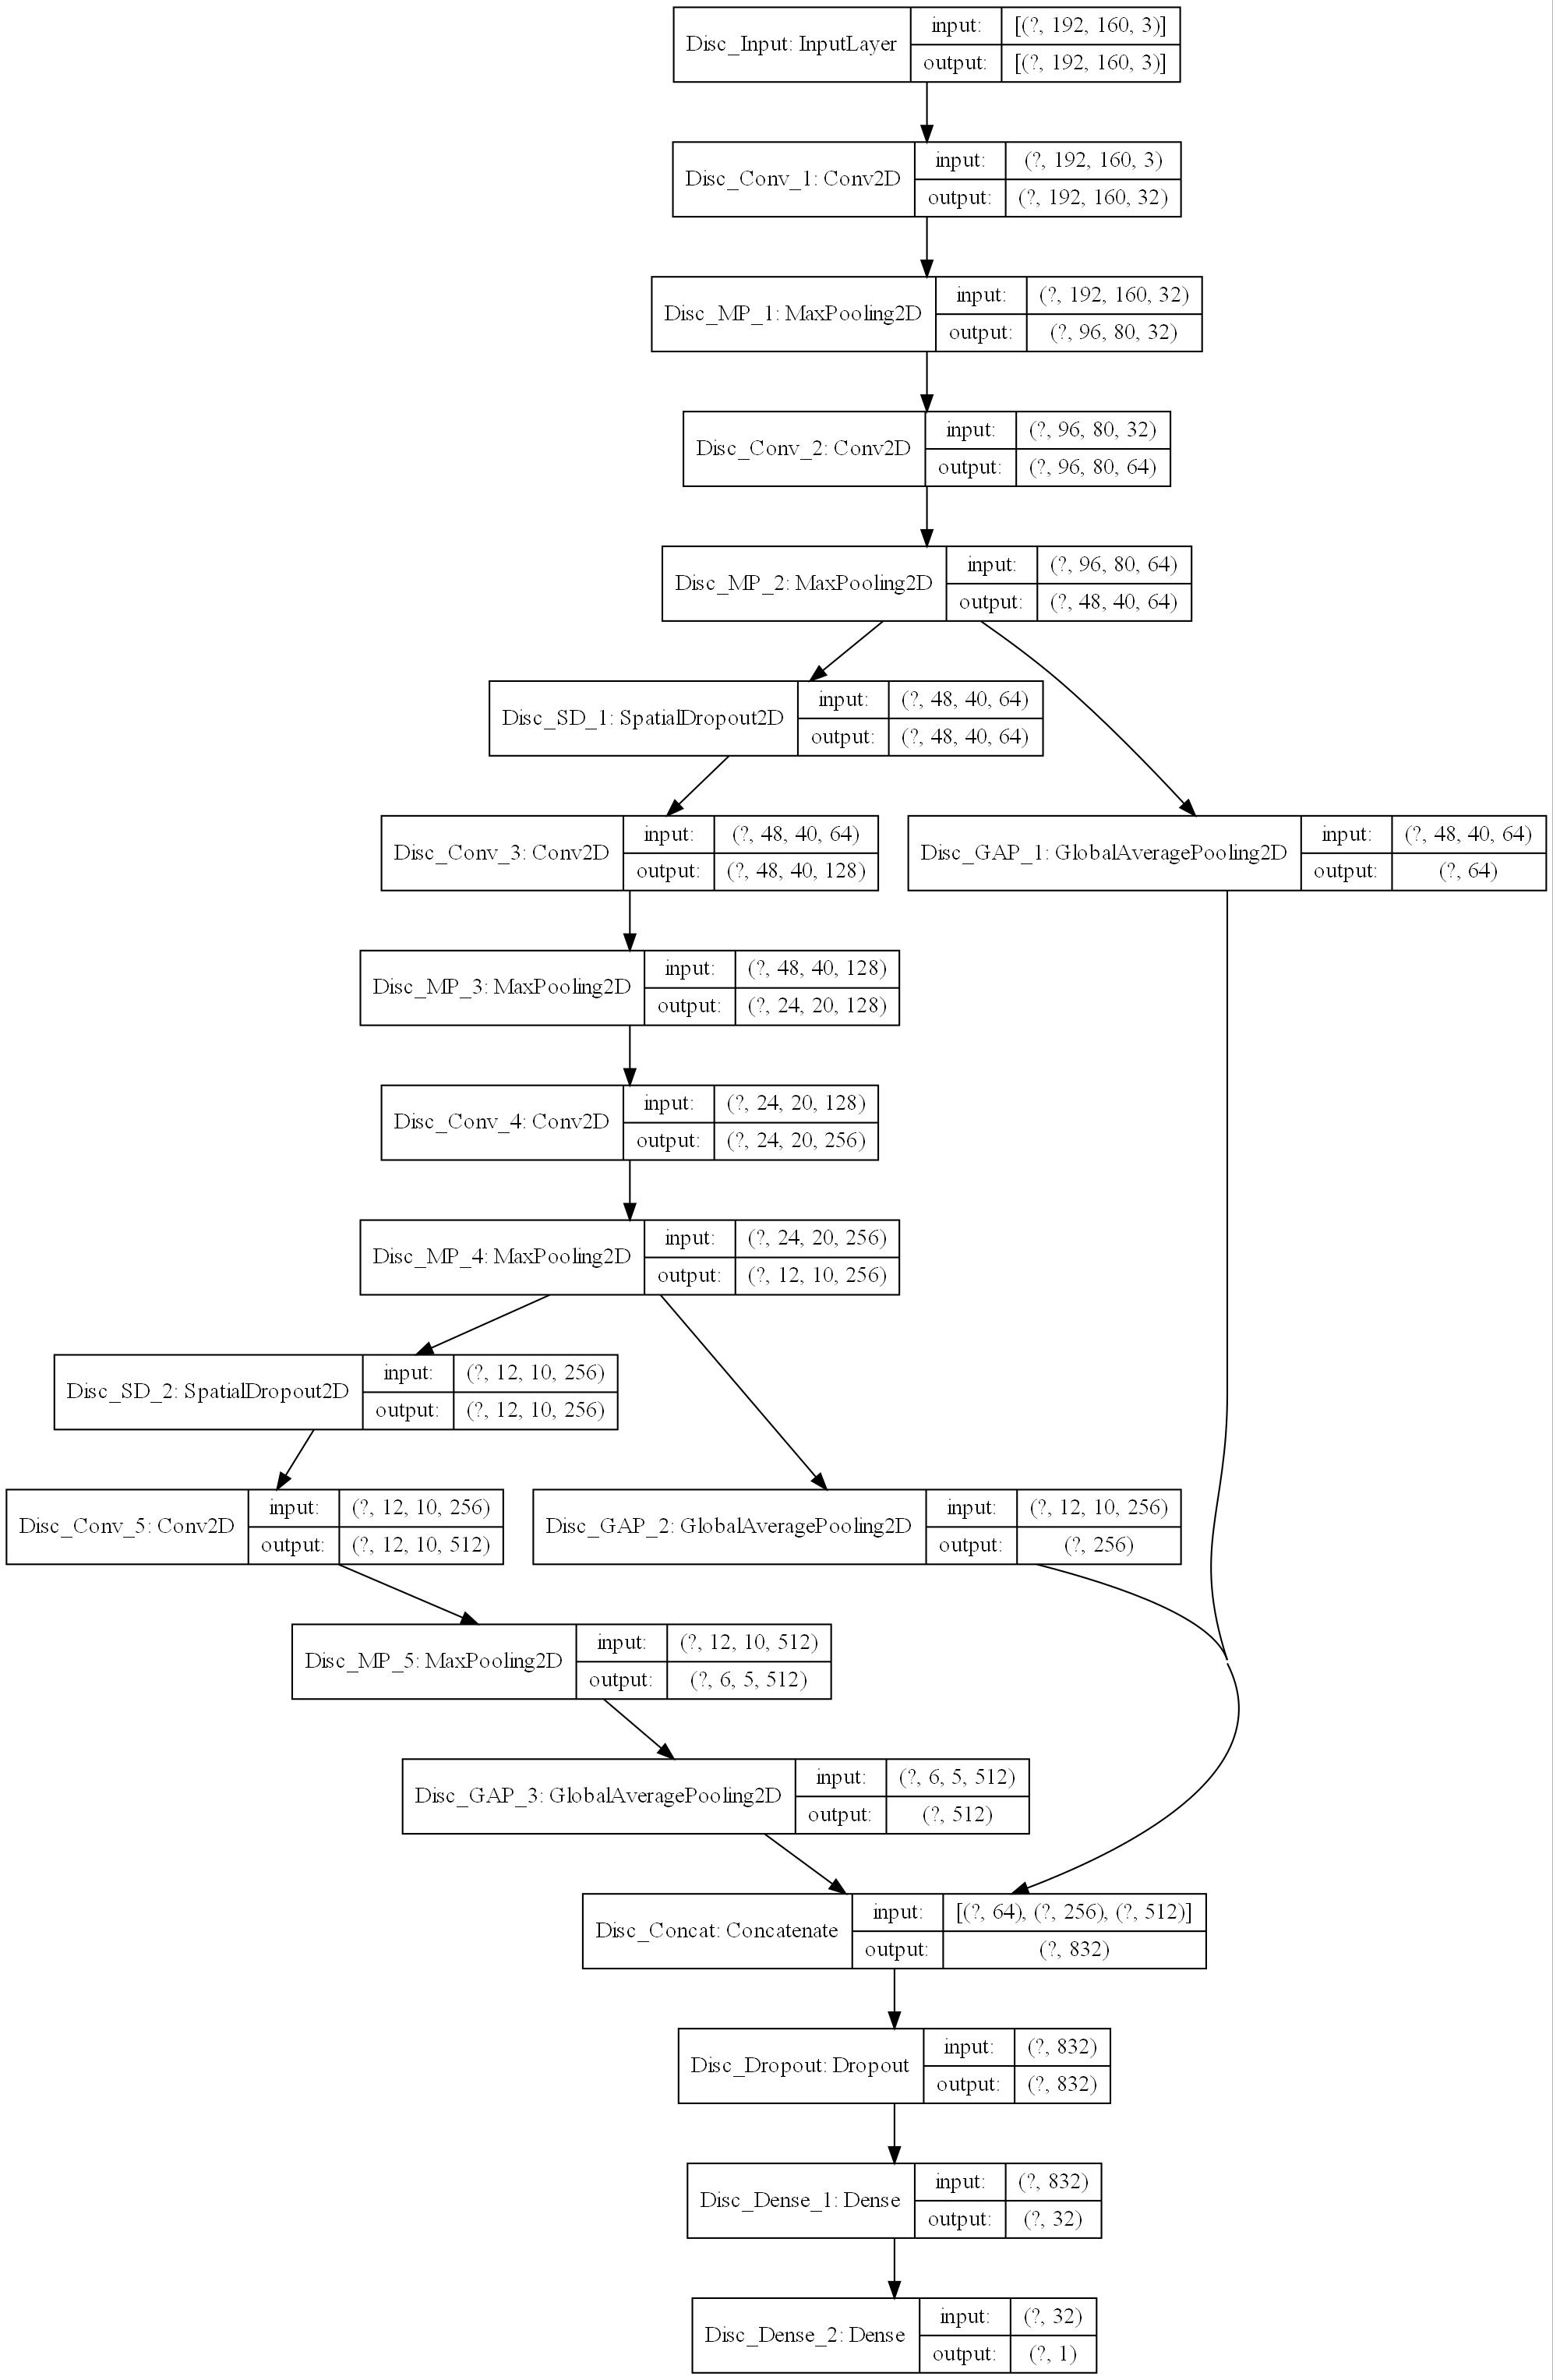

In [12]:
plot_model(discriminator, to_file = 'Discriminator.jpg', show_shapes = True, dpi = PLOTS_DPI)

## Training Pipeline

### Loss and Optimizers

In [13]:
cross_entropy = BinaryCrossentropy(from_logits = True)
gen_mean_loss = Mean(name = "Generator mean loss")
disc_mean_loss = Mean(name = "Discriminator mean loss")
generator_optimizer = Adam(GEN_LR, beta_1 = GEN_BETA_1)
discriminator_optimizer = Adam(DISC_LR, beta_1 = DISC_BETA_1)

### Restoring `checkpoint` via `CheckpointManager` if `RETRAIN` is `True`

In [14]:
checkpoint_dir = './ckpt'

checkpoint = Checkpoint(
    step = tf.Variable(1),
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    generator = generator,
    discriminator = discriminator)

ckpt_manager = CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 4)

EPOCH_START = 1
if RETRAIN:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    EPOCH_START = checkpoint.step.numpy()

print(f"Starting training from Epoch {EPOCH_START}")

Starting training from Epoch 121


### Generating images using the `generator` model

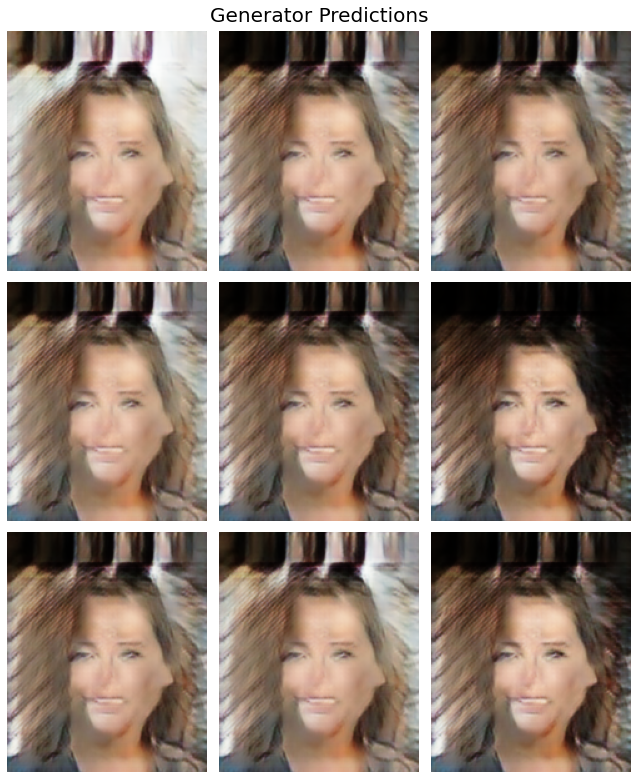

In [15]:
def generate_images(seed, save = False, epoch = None):
    pred = generator(seed, training = False)

    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (9, 11))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow((pred[i] * 0.5) + 0.5)
        ax.axis(False)
        ax.grid(False)

    plt.suptitle('Generator Predictions', fontsize = 20)
    
    plt.tight_layout()

    if save:
        plt.savefig(f'Outputs/Pred_Epoch_{epoch:04d}.png', dpi = PLOTS_DPI, facecolor = 'white', 
                transparent = False, bbox_inches = 'tight')
        plt.close()
    
generate_images(seed_noise)

### Predicting on the generated images using the `discriminator` model

In [16]:
discriminator(generator(seed_noise, training = False), training = False).numpy()

array([[-0.28915995],
       [-0.34070107],
       [-0.3436074 ],
       [-0.30369157],
       [-0.43227106],
       [-0.5862436 ],
       [-0.30587927],
       [-0.18795872],
       [-0.50115985]], dtype=float32)

### Loss functions for `generator` and `discriminator`

In [17]:
def discriminator_loss(real_output, fake_output):
    pos_labels = tf.ones_like(real_output) - (tf.random.uniform(real_output.shape) * DISC_LABEL_SMOOTHING)
    neg_labels = tf.zeros_like(fake_output) + (tf.random.uniform(fake_output.shape) * DISC_LABEL_SMOOTHING)
    real_loss = cross_entropy(pos_labels, real_output)
    fake_loss = cross_entropy(neg_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Training batch step
1. Get input noise for the `generator`
2. Generate images using the `generator` and the noise data
3. Get predictions of the `discriminator` separately on the real as well as the generated images
4. Calculate losses for the `generator` and the `discriminator` using the predictions of the previous step
5. Update the `Mean` loss metric for the epoch
6. Get gradients for the losses 
7. Apply the gradients to the `trainable_variables` of the `generator` and the `discriminator` using their optimizers

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, *GEN_NOISE_SHAPE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_mean_loss(gen_loss)
    disc_mean_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Training function
1. At start of each epoch, reset the `Mean` loss metrics
2. For each batch in the epoch, call the `train_step` function
3. Generate images using the `generator` on the seed noise data
4. Every 5 epochs, save a checkpoint
5. Display epoch metrics and progress

In [19]:
gen_losses = []
disc_losses = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_mean_loss.reset_states()
        disc_mean_loss.reset_states()
        
        print(f"\nTraining Epoch {epoch + EPOCH_START}\n")
        
        for batch_ind, image_batch in enumerate(dataset):
            train_step(image_batch)

            if (batch_ind + 1) % 10 == 0:
                print(". ", end = '')
            if (batch_ind + 1) % 250 == 0:
                print(f"{batch_ind + 1}")
        
        checkpoint.step.assign_add(1)

        display.clear_output(wait = True)
        
        generate_images(seed_noise, True, epoch + EPOCH_START)

        if (epoch + EPOCH_START) % 5 == 0:
            ckpt_manager.save()
            
        gen_losses.append(gen_mean_loss.result())
        disc_losses.append(disc_mean_loss.result())

        print(f"\nEpoch: {epoch + EPOCH_START}\n")
        print(f'Generator Loss: {gen_mean_loss.result():.4f}')
        print(f'Discriminator Loss: {disc_mean_loss.result():.4f}')
        print (f'Time elapsed: {time.time() - start:.2f} s')

    display.clear_output(wait = True)

### Model Training

In [20]:
%%time

train(train_ds, EPOCHS)

print(f'Final Generator Loss: {gen_mean_loss.result()}')
print(f'Final Discriminator Loss: {disc_mean_loss.result()}')

Final Generator Loss: 0.9691428542137146
Final Discriminator Loss: 1.2217161655426025
Wall time: 16h 3min 9s


## Output and Evaluation

### Display the images generated by the `generator` after training on the seed noise data

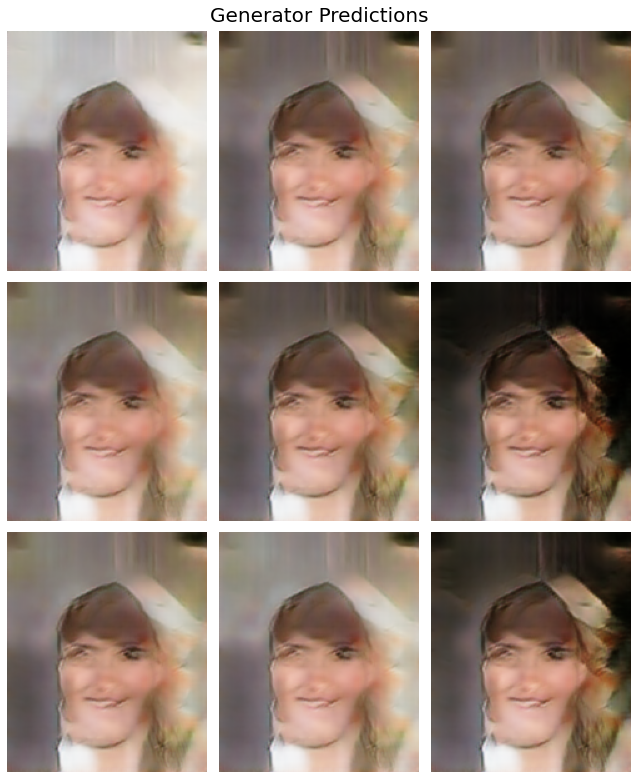

In [21]:
generate_images(seed_noise)

### Plot the loss and accuracy plots for training

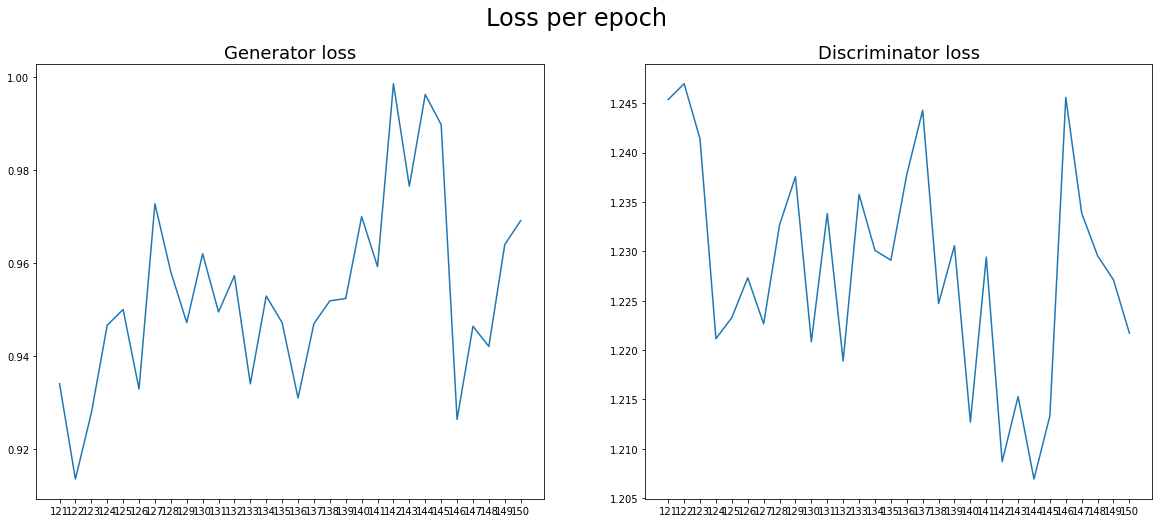

In [22]:
epoch_range = range(EPOCH_START, EPOCHS + EPOCH_START)
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
plt.plot(epoch_range, gen_losses)
plt.xticks(epoch_range)
plt.title('Generator loss', fontsize = 18)

plt.subplot(1, 2, 2)
plt.plot(epoch_range, disc_losses)
plt.xticks(epoch_range)
plt.title('Discriminator loss', fontsize = 18)

plt.suptitle('Loss per epoch', fontsize = 24)
plt.show()

## Model saving

### Save the trained models

In [23]:
generator.save("generator")
discriminator.save("discriminator")